In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, label_binarize, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC



In [3]:
df = pd.read_csv("data.csv", encoding='latin-1')
# drop salary missing rows
df=df.dropna(subset='salary')
df = df.reset_index(drop=True)
year_count = 0
month_count = 0
week_count = 0
day_count = 0
hour_count = 0
unit_count = 0

from_count = 0
upto_count = 0 
dash_count = 0
interval_year_idx = []
# year_dash = []
other = []

for idx, salary in enumerate(df['salary'], 0):
    hour = re.search(r'hour', salary)
    day = re.search(r'day', salary)
    week = re.search(r'week', salary)
    month = re.search(r'month', salary)
    year = re.search(r'year', salary)
    from_ = re.search(r'From', salary)
    upto = re.search(r'Up', salary)
    dash = re.search(r'-', salary)
    if hour:
        hour_count += 1
    elif day:
        day_count += 1
    elif week:
        week_count += 1
    elif month:
        month_count += 1
    elif year:
        year_count += 1
        if dash:
            interval_year_idx.append(idx)
            # year_dash.append(salary)
    else:
        unit_count += 1
        
    if from_:
        from_count += 1
    elif upto:
        upto_count += 1
    elif dash:
        dash_count += 1
    else:
        other.append(salary)
print("hour count:", hour_count)
print("day count:", day_count)
print("week count:", week_count)
print("month count:", month_count)
print("year count:", year_count)
print('other unit count:', unit_count)
print("total = ", hour_count + day_count + week_count + month_count + year_count)


print("\nfrom count:", from_count)
print("upto count:", upto_count)
print("dash count:", dash_count)

hour count: 3198
day count: 33
week count: 15
month count: 317
year count: 14540
other unit count: 0
total =  18103

from count: 1788
upto count: 665
dash count: 14434


In [4]:
# drop the salary whose format is not interval and yearly
df = df[df.index.isin(interval_year_idx)]
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11824 entries, 0 to 11823
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  11824 non-null  object 
 1   company                11824 non-null  object 
 2   salary                 11824 non-null  object 
 3   rating                 11824 non-null  float64
 4   review_count           11824 non-null  int64  
 5   types                  10410 non-null  object 
 6   location               11824 non-null  object 
 7   relative_time          11824 non-null  object 
 8   hires_needed           5088 non-null   object 
 9   hires_needed_exact     8125 non-null   object 
 10  urgently_hiring        11824 non-null  bool   
 11  remote_work_model      6800 non-null   object 
 12  snippet                11824 non-null  object 
 13  dradis_job             11824 non-null  bool   
 14  link                   11824 non-null  object 
 15  ne

### Generate New Feature

In [5]:
df.drop(['link', 'company_overview_link', 'job_link'], axis=1, inplace=True) # drop link
df.drop(['ad_id', 'source_id', 'job_location_postal'], axis=1, inplace=True) # drop meaningless values for salary
df.drop('indeed_apply_enabled', axis=1, inplace=True) # drop correlation=1 features
df.columns

Index(['title', 'company', 'salary', 'rating', 'review_count', 'types',
       'location', 'relative_time', 'hires_needed', 'hires_needed_exact',
       'urgently_hiring', 'remote_work_model', 'snippet', 'dradis_job',
       'new_job', 'sponsored', 'featured_employer', 'indeed_applyable',
       'remote_location', 'hiring_event_job', 'activity_date',
       'location_extras'],
      dtype='object')

In [6]:
df['salary_min'] = df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[0].replace(',', '', regex=True).astype(float)
df['salary_max'] = df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[1].replace(',', '', regex=True).astype(float)
# df['salary_unit'] = df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[2]

df['average_salary'] = (df['salary_min'] + df['salary_max']) / 2

# Calculate the ratio M/m
df['salary_ratio'] = df['salary_max'] / df['salary_min']

# Classify into Low, Medium, or High based on the specified criteria
df['salary_range'] = pd.cut(df['salary_ratio'],
                            bins=[-float('inf'), 1.25, 1.5, float('inf')],
                            labels=['Low', 'Medium', 'High'],
                            right=False) # Ensure that the intervals are left-closed


# Print the count of each salary range
print(df['salary_range'].value_counts())

salary_range
Medium    5331
High      3480
Low       3013
Name: count, dtype: int64


### Missing map

In [7]:
df.drop(['location_extras', 'relative_time', 'hires_needed', 'activity_date'], axis=1, inplace=True) # drop preprocessed data
# Drop text features for simplicity
df.drop(['title'], axis=1, inplace=True)

missing value count:
company                  0
salary                   0
rating                   0
review_count             0
types                 1414
location                 0
hires_needed_exact    3699
urgently_hiring          0
remote_work_model     5024
snippet                  0
dradis_job               0
new_job                  0
sponsored                0
featured_employer        0
indeed_applyable         0
remote_location          0
hiring_event_job         0
salary_min               0
salary_max               0
average_salary           0
salary_ratio             0
salary_range             0
dtype: int64


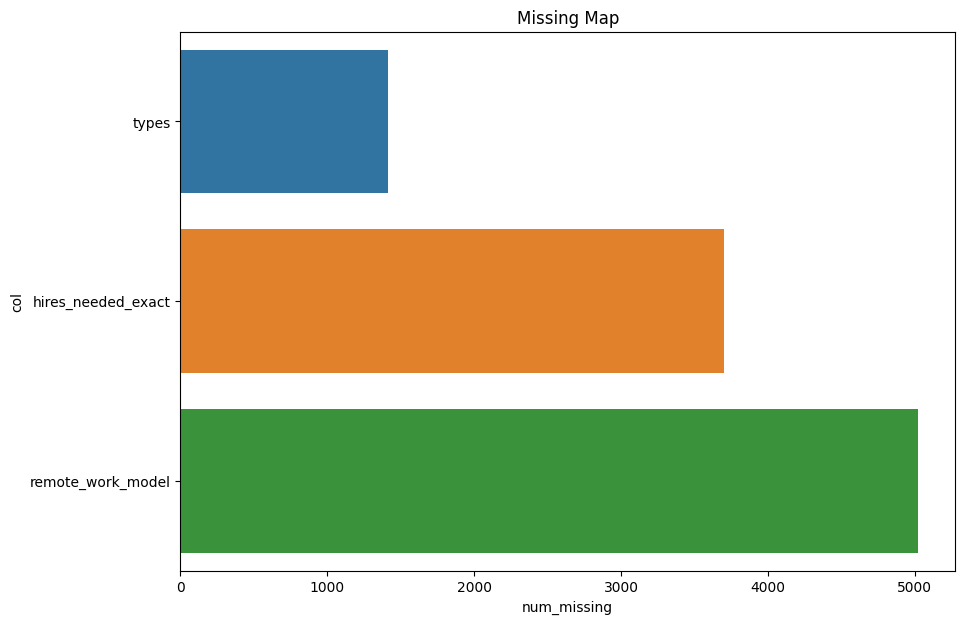

In [8]:
miss_cnt = df.isnull().sum()
print("missing value count:")
print(miss_cnt)
missing = miss_cnt[miss_cnt > 0]
if missing.empty:
    print("There are no missing values")
else:
    # print missing map
    missing.sort_values(inplace=True)
    missing_df = pd.DataFrame({'col': missing.index, 'num_missing': missing.values})

    plt.figure(figsize=(10,7))
    plt.title('Missing Map')
    sns.barplot(y='col', x='num_missing', data=missing_df)
    plt.show()

### Text Classification

In [9]:
# CountVectorizer

# Separate features and target variable
X_text = df['snippet']
y = df['salary_range']

# Split the dataset into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Define the text preprocessing and SVM pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),  # Convert text to a matrix of token counts
    ('clf', SVC(kernel='linear'))  # Linear SVM classifier
])

# Train the text classifier
text_clf.fit(X_train_text, y_train)

# Make predictions on the test set
y_pred_text = text_clf.predict(X_test_text)

# Evaluate the performance of the text classifier
accuracy_text = accuracy_score(y_test, y_pred_text)
print(f"Text Classification Accuracy: {accuracy_text:.2f}")

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_text))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_text))

Text Classification Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

        High       0.86      0.87      0.86       663
         Low       0.86      0.82      0.84       599
      Medium       0.91      0.92      0.92      1103

    accuracy                           0.88      2365
   macro avg       0.88      0.87      0.87      2365
weighted avg       0.88      0.88      0.88      2365

Confusion Matrix:
[[ 577   45   41]
 [  48  493   58]
 [  49   35 1019]]


In [ ]:
X = df['snippet']
y = df['salary_range']

y = y.map({'Medium': 0, 'High': 1, 'Low': 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train_tfidf, y_train)

y_pred = svm_classifier.predict(X_test_tfidf)

print("Text Classification Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


### Classification

In [10]:
df.columns

Index(['company', 'salary', 'rating', 'review_count', 'types', 'location',
       'hires_needed_exact', 'urgently_hiring', 'remote_work_model', 'snippet',
       'dradis_job', 'new_job', 'sponsored', 'featured_employer',
       'indeed_applyable', 'remote_location', 'hiring_event_job', 'salary_min',
       'salary_max', 'average_salary', 'salary_ratio', 'salary_range'],
      dtype='object')

In [13]:

# Separate features and target variable
X = df.drop(['salary', 'salary_min', 'salary_max', 'average_salary', 'salary_ratio', 'salary_range'], axis=1)
y = df['salary_range']

# Identify categorical columns
boolean_features = ['urgently_hiring', 'dradis_job', 'new_job', 'sponsored', 'featured_employer',
                    'indeed_applyable', 'remote_location', 'hiring_event_job']

categorical_features = ['types', 'remote_work_model', 'hires_needed_exact', 'company']

numerical_features = ['rating', 'review_count']

text_features = ['snippet']

# Define preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for boolean and categorical data
boolean_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# # Define preprocessing for text data
# text_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='')),
#     # converts the 'snippet' text data into a numerical format
#     ('tfidf', TfidfVectorizer(analyzer=lambda x: x))
#     # analyzer=lambda x: x is used to treat each element in the 'snippet' column as a single token. 
#     # This means that the vectorizer considers each entire text snippet as a single unit, rather than breaking it down into individual words.
#     # The resulting output is a sparse matrix representing the TF-IDF features of the text data.
# ])

from sklearn.base import TransformerMixin

class ArrayToStringConverter(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # for row in X:
        #     print(map(str, row))
        return [' '.join(map(str, row)) for row in X]

# Define preprocessing for text data
text_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('array_to_string', ArrayToStringConverter()),
    ('tfidf', TfidfVectorizer(analyzer='word', stop_words='english', max_features=5000))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bool_cat', boolean_categorical_transformer, boolean_features + categorical_features),
        ('text', text_transformer, text_features)
    ])

# # Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the dataset into test (10%) and train (90%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Further split the training set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the target variable to binary format
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])



In [ ]:
# # Original Data
# text_data = [
#     ["Reports to* DIRECTOR OF MARKETING.\n PHP - Equivalent of 3 years education and/or experience.\n Java script - Equivalent of 3 years education and/or experience."],
#     ["Embedded software: 3 years (Required).\n This position is primarily a software engineering role focused on both design and implementation, but also part of a¡K"]
# ]

# # # Imputation
# # imputer = SimpleImputer(strategy='constant', fill_value='')
# # text_data_imputed = imputer.transform(text_data)

# # print("After Imputation:")
# # for snippet in text_data_imputed:
# #     print(snippet[0][:50] + "...\n")  # Print first 50 characters for brevity
# # print("\n")

# # Array to String Conversion
# array_to_string_converter = ArrayToStringConverter()
# text_data_flattened = array_to_string_converter.transform(text_data)

# print("After Array to String Conversion:")
# for snippet in text_data_flattened:
#     print(snippet[:50] + "...\n")  # Print first 50 characters for brevity
# print("\n")

# # TF-IDF Vectorization
# tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', max_features=5000)
# text_data_tfidf = tfidf_vectorizer.fit_transform(text_data_flattened)

# print("After TF-IDF Vectorization:")
# # Print the first few words in the vocabulary
# print(list(tfidf_vectorizer.vocabulary_.keys())[:10])
# # Print the first few values in the first document's TF-IDF matrix
# print(text_data_tfidf[0, :10].toarray())


LogisticRegression

Logistic Regression Cross-Validation Scores: [0.89782736 0.89430417 0.90305523 0.90188014 0.90716804]
Logistic Regression Cross-Validated Accuracy: 0.90 +/- 0.00
Logistic Regression Validation Accuracy: 0.89
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       627
           1       0.84      0.87      0.86       542
           2       0.92      0.91      0.91       960

    accuracy                           0.89      2129
   macro avg       0.89      0.89      0.89      2129
weighted avg       0.89      0.89      0.89      2129

Validation Confusion Matrix:
[[554  38  35]
 [ 28 473  41]
 [ 38  49 873]]
Logistic Regression Val Micro Average AUC = 0.98
Logistic Regression Val Macro Average AUC = 0.98
Logistic Regression Val Class 0 AUC = 0.99
Logistic Regression Val Class 1 AUC = 0.98
Logistic Regression Val Class 2 AUC = 0.98


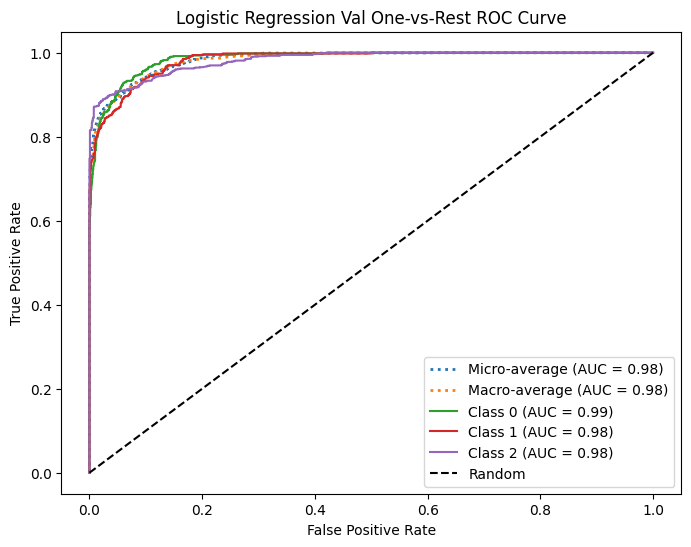

Logistic Regression Test Accuracy: 0.91
Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       348
           1       0.87      0.87      0.87       302
           2       0.93      0.92      0.93       533

    accuracy                           0.91      1183
   macro avg       0.90      0.91      0.91      1183
weighted avg       0.91      0.91      0.91      1183

Test Confusion Matrix:
[[321  15  12]
 [ 13 264  25]
 [ 18  24 491]]
Logistic Regression Test Micro Average AUC = 0.99
Logistic Regression Test Macro Average AUC = 0.99
Logistic Regression Test Class 0 AUC = 0.99
Logistic Regression Test Class 1 AUC = 0.98
Logistic Regression Test Class 2 AUC = 0.99


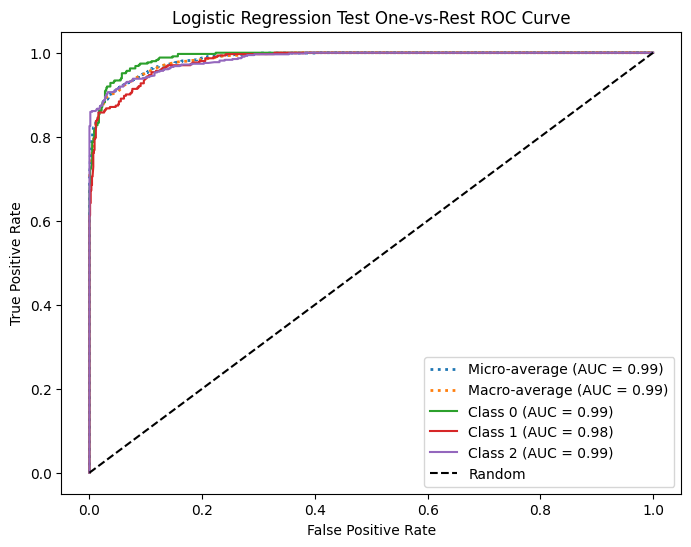

In [14]:
# Define the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("Logistic Regression Cross-Validation Scores:", cv_scores)
print(f"Logistic Regression Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Logistic Regression Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for the validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Val Micro Average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Val Macro Average AUC = {roc_auc_macro:.2f}")
# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Logistic Regression Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Logistic Regression Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for the test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Test Micro Average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Test Macro Average AUC = {roc_auc_micro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Logistic Regression Test Class {i} AUC = {roc_auc[i]:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


SVM

SVM Cross-Validation Scores: [0.90839695 0.90604815 0.91363102 0.90658049 0.91304348]
SVM Cross-Validated Accuracy: 0.91 +/- 0.00
SVM Validation Accuracy: 0.90
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       627
           1       0.85      0.89      0.87       542
           2       0.93      0.92      0.92       960

    accuracy                           0.90      2129
   macro avg       0.90      0.90      0.90      2129
weighted avg       0.90      0.90      0.90      2129

Validation Confusion Matrix:
[[555  40  32]
 [ 24 482  36]
 [ 30  47 883]]
SVM Val Micro-average AUC = 0.98
SVM Val Macro-average AUC = 0.98
SVM Val Class 0 AUC = 0.99
SVM Val Class 1 AUC = 0.98
SVM Val Class 2 AUC = 0.98


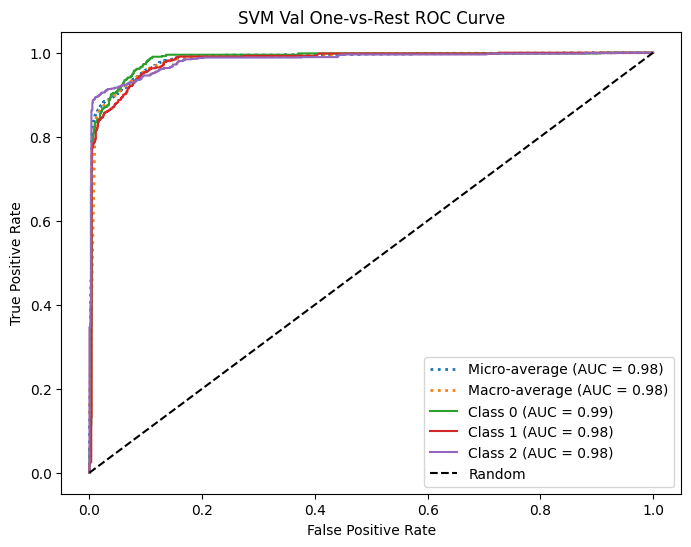

SVM Test Accuracy: 0.91
Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       348
           1       0.87      0.88      0.88       302
           2       0.92      0.92      0.92       533

    accuracy                           0.91      1183
   macro avg       0.91      0.91      0.91      1183
weighted avg       0.91      0.91      0.91      1183

Test Confusion Matrix:
[[316  16  16]
 [ 10 267  25]
 [ 15  25 493]]
SVM Test Micro-average AUC = 0.98
SVM Test Macro-average AUC = 0.98
SVM Test Class 0 AUC = 0.99
SVM Test Class 1 AUC = 0.98
SVM Test Class 2 AUC = 0.98


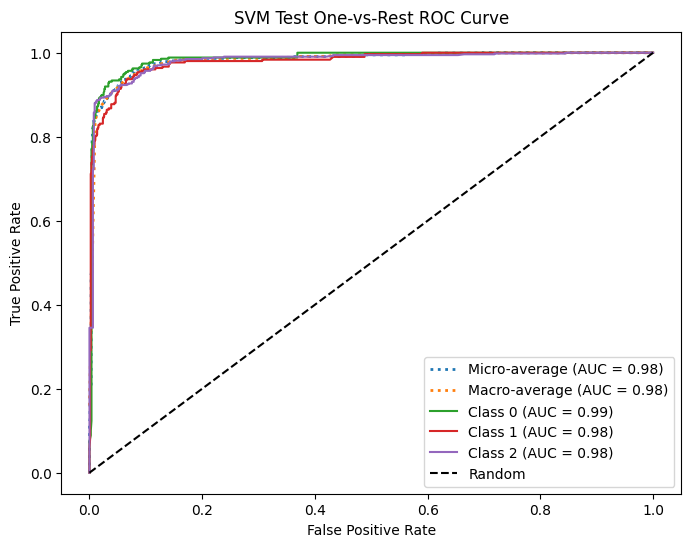

In [15]:
# Define the model
# model = SVC(C=10, probability=True, random_state=42, decision_function_shape='ovr', kernel='rbf')
model = SVC(C=10, probability=True, random_state=42, decision_function_shape='ovr', kernel='poly', gamma='scale',
            class_weight={0: class_weights[0], 1: class_weights[1], 2: class_weights[2]})

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("SVM Cross-Validation Scores:", cv_scores)
print(f"SVM Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"SVM Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for the validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Val Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Val Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"SVM Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"SVM Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for the test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Test Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Test Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"SVM Test Class {i} AUC = {roc_auc[i]:.2f}")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid to search
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Fit the model with the best hyperparameters on the entire training set
clf = grid_search.best_estimator_




DecisionTreeClassifier

Decision Tree Cross-Validation Scores: [0.86905461 0.87844979 0.87837838 0.87132785 0.87544066]
Decision Tree Cross-Validated Accuracy: 0.87 +/- 0.00
Decision Tree Validation Accuracy: 0.87
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       627
           1       0.81      0.83      0.82       542
           2       0.90      0.91      0.90       960

    accuracy                           0.87      2129
   macro avg       0.86      0.86      0.86      2129
weighted avg       0.87      0.87      0.87      2129

Validation Confusion Matrix:
[[520  57  50]
 [ 41 450  51]
 [ 37  49 874]]
Decision Tree Val Micro-average AUC = 0.90
Decision Tree Val Macro-average AUC = 0.90
Decision Tree Val Class 0 AUC = 0.89
Decision Tree Val Class 1 AUC = 0.89
Decision Tree Val Class 2 AUC = 0.92


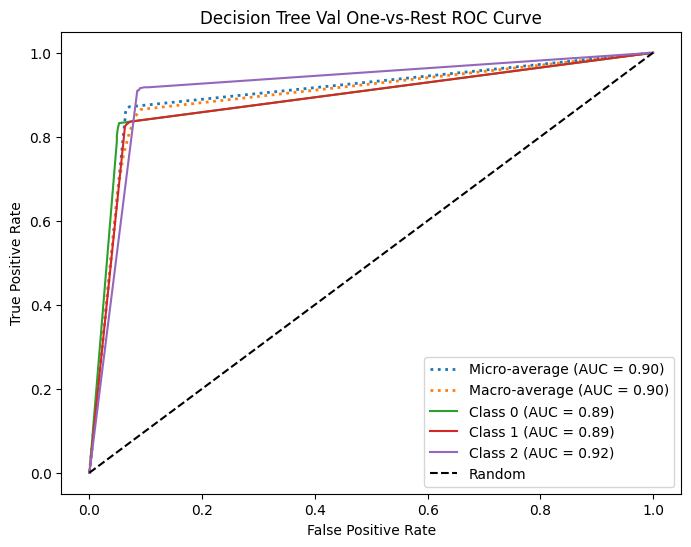

Decision Tree Test Accuracy: 0.86
Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       348
           1       0.83      0.79      0.81       302
           2       0.87      0.91      0.89       533

    accuracy                           0.86      1183
   macro avg       0.86      0.85      0.86      1183
weighted avg       0.86      0.86      0.86      1183

Test Confusion Matrix:
[[296  22  30]
 [ 21 240  41]
 [ 20  28 485]]
Decision Tree Test Micro-average AUC = 0.90
Decision Tree Test Macro-average AUC = 0.89
Decision Tree Test Class 0 AUC = 0.91
Decision Tree Test Class 1 AUC = 0.87
Decision Tree Test Class 2 AUC = 0.90


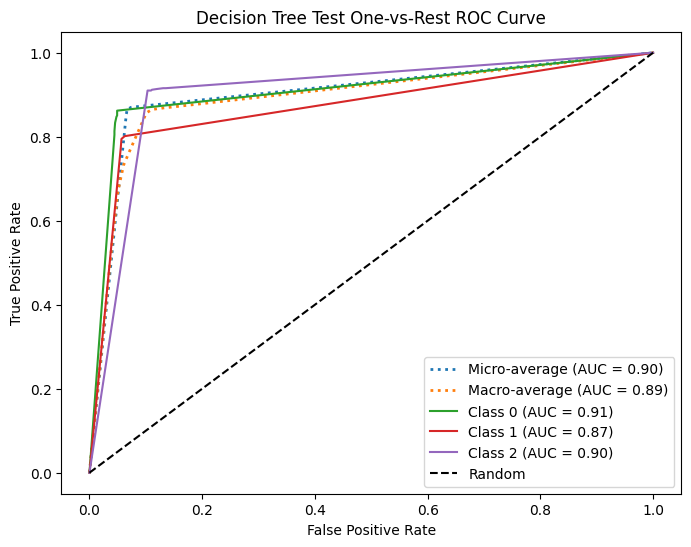

In [16]:
# Define the model
model = DecisionTreeClassifier(random_state=42)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("Decision Tree Cross-Validation Scores:", cv_scores)
print(f"Decision Tree Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Decision Tree Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Val Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Val Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Decision Tree Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Decision Tree Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Test Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Test Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Decision Tree Test Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


RandomForestClassifier

Random Forest Cross-Validation Scores: [0.88725778 0.89547857 0.89776733 0.89835488 0.90364277]
Random Forest Cross-Validated Accuracy: 0.90 +/- 0.01
Random Forest Validation Accuracy: 0.89
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       627
           1       0.84      0.88      0.86       542
           2       0.92      0.91      0.92       960

    accuracy                           0.89      2129
   macro avg       0.89      0.89      0.89      2129
weighted avg       0.89      0.89      0.89      2129

Validation Confusion Matrix:
[[550  38  39]
 [ 31 476  35]
 [ 31  54 875]]
Decision Tree Val Micro-average AUC = 0.99
Decision Tree Val Macro-average AUC = 0.99
Random Forest Val Class 0 AUC = 0.99
Random Forest Val Class 1 AUC = 0.98
Random Forest Val Class 2 AUC = 0.99


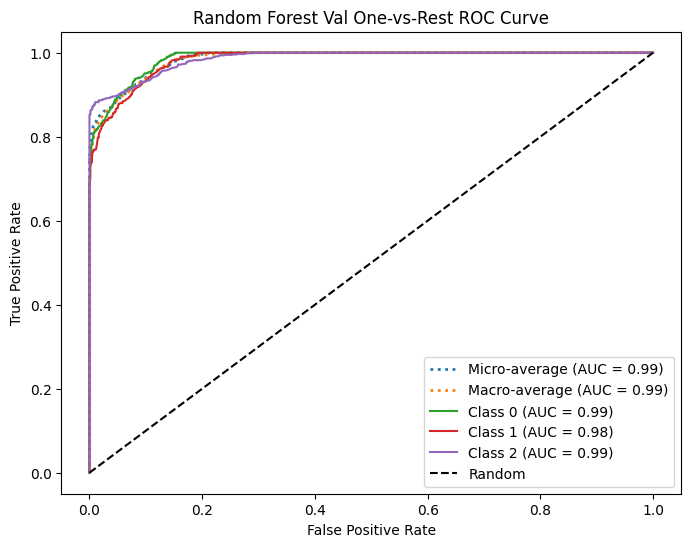

Random Forest Test Accuracy: 0.90
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       348
           1       0.86      0.86      0.86       302
           2       0.92      0.92      0.92       533

    accuracy                           0.90      1183
   macro avg       0.89      0.89      0.89      1183
weighted avg       0.90      0.90      0.90      1183

Test Confusion Matrix:
[[316  15  17]
 [ 19 259  24]
 [ 17  26 490]]
Decision Tree Test Micro-average AUC = 0.99
Decision Tree Test Macro-average AUC = 0.99
Random Forest Test Class 0 AUC = 0.99
Random Forest Test Class 1 AUC = 0.98
Random Forest Test Class 2 AUC = 0.99


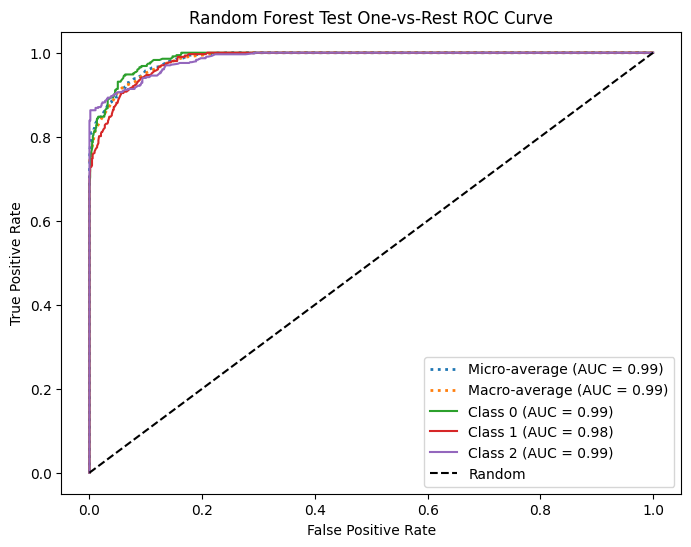

In [17]:
# Define the model
model = RandomForestClassifier(n_estimators=200, random_state=42)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("Random Forest Cross-Validation Scores:", cv_scores)
print(f"Random Forest Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Random Forest Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for the validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Val Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Val Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Random Forest Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Random Forest Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for the test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Test Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Test Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Random Forest Test Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()
